In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torchphysics as tp 
import torch
import numpy as np
import torch

X = tp.spaces.R2('x') # input is 2D
U = tp.spaces.R1('u') # output is 1D

Creates the plot for one single entry of the dataset for PINNs and QRES

In [2]:
square = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])

In [3]:
# here set the structure of the newtwork:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(50, 50, 50))
#model = tp.models.QRES(input_space=X, output_space=U, hidden=(36,36, 36))

In [4]:
scaling = 10
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X) 
f = scaling * torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
pde_sampler = tp.samplers.DataSampler(xx)

513.0


In [5]:
def pde_residual(u, x):
    return tp.utils.laplacian(u, x) + f
 

pde_cond = tp.conditions.PINNCondition(module=model, sampler=pde_sampler, 
                                       residual_fn=pde_residual)

In [6]:
# boundary condition:
def bound_residual(u):
    return u

bound_sampler = tp.samplers.GridSampler(square.boundary, n_points=2052).make_static()
bound_cond = tp.conditions.PINNCondition(module=model, sampler=bound_sampler, 
                                         residual_fn=bound_residual, weight=10000)

In [7]:
# here we start with Adam:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver(train_conditions=[pde_cond, bound_cond], optimizer_setting=optim)

In [8]:
import pytorch_lightning as pl

f = f.to('cuda')
trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=5000, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Switch to LBFGS

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.2, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

solver = tp.solver.Solver(train_conditions=[pde_cond, bound_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=8000, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

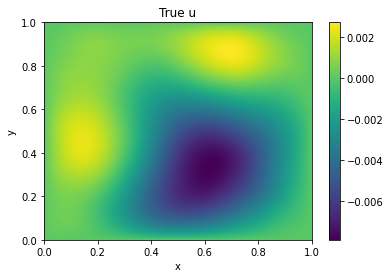

In [ ]:
import matplotlib.pyplot as plt
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X)
true_data = torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"True u")
plt.imshow(true_data[:, 1].reshape(Nx+1, Nx+1), extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()

testing time: 0.0038003921508789062


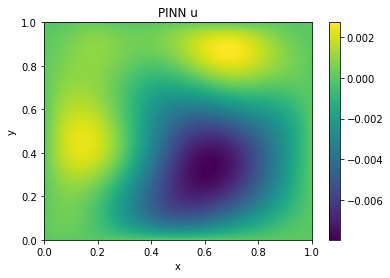

In [ ]:
import time
# first move the GPU:
xx = xx.to('cuda:0')
model.to('cuda:0')
start = time.time()
#u_out = u_constrain(model(xx).as_tensor, xx.as_tensor)
u_out = model(xx)
print('testing time:', time.time() - start)
u_out = (u_out.as_tensor/ scaling).detach().cpu().numpy().reshape(1, Nx+1, Nx+1)
fig = plt.figure() #figsize=(10+4, 5)
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"PINN u")
plt.imshow(u_out[0], extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()

tensor(0.0121)


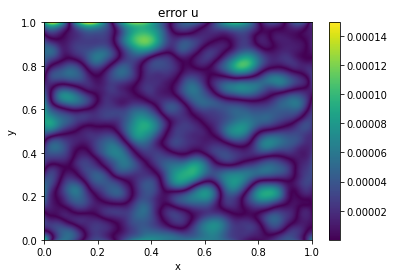

In [ ]:
fig = plt.figure() #figsize=(10+4, 5)
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"error u")
diff = np.abs(u_out[0]-true_data[:, 1].numpy().reshape(Nx+1, Nx+1))
l2_rel = np.sqrt(np.sum(diff**2))/np.sqrt(sum(true_data[:, 1]**2))
plt.imshow(diff, 
           extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()
print(l2_rel)